<a href="https://colab.research.google.com/github/mdbresh/HyperUnmixing/blob/master/HyperUnmixing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title 1- Import modules
import pyUSID as usid # $pip install pyUSID
import h5py #$pip install h5py
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
%matplotlib inline

#load pydrive to load data
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


Load modified modules: google drive and pifm modules from the pycroscopy github 

In [0]:
#@title 2- Load custom modules
'''
This module was downloaded from the pycroscopy github page: https://github.com/pycroscopy/pycroscopy
It was edited slightly with contributor Jessica Kong @kongjy to accomodate the new format
in which PiFM data is taken with a polarizer installed.
'''


import os
import numpy as np
from pyUSID.io.translator import Translator
from pyUSID.io import write_utils
from pyUSID import USIDataset
import pyUSID as usid
import h5py

class PiFMTranslator(Translator):
    """
    Class that writes images, spectrograms, point spectra and associated ancillary data sets to h5 file in pyUSID data
    structure.
    """

    def translate(self, path, append_path='', grp_name='Measurement'):
        """
        Parameters
        ----------
        file_path : String / unicode
            Absolute path of the .ibw file
        verbose : Boolean (Optional)
            Whether or not to show  print statements for debugging
        append_path : string (Optional)
            h5_file to add these data to, must be a path to the h5_file on disk
        parm_encoding : str, optional
            Codec to be used to decode the bytestrings into Python strings if needed.
            Default 'utf-8'

        Returns
        -------
        h5_path : String / unicode
            Absolute path of the .h5 file
        """
        self.get_path(path)
        self.read_anfatec_params()
        self.read_file_desc()
        self.read_spectrograms()
        self.read_imgs()
        self.read_spectra()
        self.make_pos_vals_inds_dims()
        self.create_hdf5_file(append_path, grp_name)
        self.write_spectrograms()
        self.write_images()
        self.write_spectra()
        self.write_ps_spectra()

        return self.h5_f


    def get_path(self, path):
        """writes full path, directory, and file name as attributes to class"""
        # get paths/get params dictionary, img/spectrogram/spectrum descriptions

        self.path = path
        full_path = os.path.realpath(self.path)
        directory = os.path.dirname(full_path)
        # file name
        basename = os.path.basename(self.path)
        self.full_path = full_path
        self.directory = directory
        self.basename = basename

    #these dictionary parameters will be written to hdf5 file under measurement attributes
    def read_anfatec_params(self):
        """reads the scan parameters and writes them to a dictionary"""
        params_dictionary = {}
        params = True
        with open(self.path, 'r', encoding="ISO-8859-1") as f:
            for line in f:
                if params:
                    sline = [val.strip() for val in line.split(':')]
                    if len(sline) == 2 and sline[0][0] != ';':
                        params_dictionary[sline[0]] = sline[1]
                    #in ANFATEC parameter files, all attributes are written before file references.
                    if sline[0].startswith('FileDesc'):
                        params = False
            f.close()
        self.params_dictionary = params_dictionary
        self.x_len, self.y_len = int(params_dictionary['xPixel']), int(params_dictionary['yPixel'])

    def read_file_desc(self):
        """reads spectrogram, image, and spectra file descriptions and stores all to dictionary where
        the key:value pairs are filename:[all descriptors]"""
        spectrogram_desc = {}
        img_desc = {}
        spectrum_desc = {}
        pspectrum_desc = {}
        with open(self.path,'r', encoding="ISO-8859-1") as f:
            ## can be made more concise...by incorporating conditons with loop control
            lines = f.readlines()
            for index, line in enumerate(lines):
                sline = [val.strip() for val in line.split(':')]
                #if true, then file describes image.
                if sline[0].startswith('FileDescBegin'):
                    no_descriptors = 5
                    file_desc = []
                    for i in range(no_descriptors):
                        line_desc = [val.strip() for val in lines[index+i+1].split(':')]
                        file_desc.append(line_desc[1])
                    #img_desc['filename'] = caption, scale, physical unit, offset
                    img_desc[file_desc[0]] = file_desc[1:]
                #if true, file describes spectrogram (ie hyperspectral image)
                if sline[0].startswith('FileDesc2Begin'):
                    no_descriptors = 10
                    file_desc = []
                    for i  in range(no_descriptors):
                        line_desc = [val.strip() for val in lines[index+i+1].split(':')]
                        file_desc.append(line_desc[1])
                    #caption, bytes perpixel, scale, physical unit, offset, offset, datatype, bytes per reading
                    #filename wavelengths, phys units wavelengths.
                    spectrogram_desc[file_desc[0]] = file_desc[1:]
                if sline[0].startswith('AFMSpectrumDescBegin'):

                    file_desc = []
                    line_desc = [val.strip() for val in lines[index+1].split(':')][1]
                    if 'powerspectrum' in line_desc:
                        no_descriptors = 2
                        for i in range(no_descriptors):
                            line_desc = [val.strip() for val in lines[index+i+1].split(':')]
                            file_desc.append(line_desc[1])
                        #file name, position x, position y
                        pspectrum_desc[file_desc[0]] = file_desc[1:]
                    else:
                        no_descriptors = 7
                        for i in range(no_descriptors):
                            line_desc = [val.strip() for val in lines[index+i+1].split(':')]
                            file_desc.append(line_desc[1])
                        #file name, position x, position y
                        spectrum_desc[file_desc[0]] = file_desc[1:]
            f.close()
        self.img_desc = img_desc
        self.spectrogram_desc = spectrogram_desc
        self.spectrum_desc = spectrum_desc
        self.pspectrum_desc = pspectrum_desc

    def read_spectrograms(self):
        """reads spectrograms, associated spectral values, and saves them in two dictionaries"""
        spectrograms = {}
        spectrogram_spec_vals = {}
        for file_name, descriptors in self.spectrogram_desc.items():
            # load and save spectroscopic values
            spec_vals_i = np.loadtxt(os.path.join(self.directory, file_name.strip('.int') + 'Wavelengths.txt'))
            #if true, data is acquired with polarizer, with an attenuation data column
            if np.array(spec_vals_i).ndim == 2:
                spectrogram_spec_vals[file_name] = spec_vals_i[:,0]
                attenuation = {}
                attenuation[file_name] = spec_vals_i[:,1]
                self.attenuation = attenuation
            else:
                spectrogram_spec_vals[file_name] = spec_vals_i
            # load and save spectrograms
            spectrogram_i = np.fromfile(os.path.join(self.directory, file_name), dtype='i4')
            spectrograms[file_name] = np.zeros((self.x_len, self.y_len, len(spec_vals_i)))
            for y, line in enumerate(np.split(spectrogram_i, self.y_len)):
                for x, pt_spectrum in enumerate(np.split(line, self.x_len)):
                    spectrograms[file_name][x, y, :] = pt_spectrum * float(descriptors[2])
        self.spectrograms = spectrograms
        self.spectrogram_spec_vals = spectrogram_spec_vals

    def read_imgs(self):
        """reads images and saves to dictionary"""
        imgs = {}
        for file_name, descriptors in self.img_desc.items():
            img_i = np.fromfile(os.path.join(self.directory, file_name), dtype='i4')
            imgs[file_name] = np.zeros((self.x_len, self.y_len))
            for y, line in enumerate(np.split(img_i, self.y_len)):
                for x, pixel in enumerate(np.split(line, self.x_len)):
                    imgs[file_name][x, y] = pixel * float(descriptors[1])
        self.imgs = imgs

    def read_spectra(self):
        """reads all point spectra and saves to dictionary"""
        spectra = {}
        spectra_spec_vals = {}
        spectra_x_y_dim_name = {}
        for file_name, descriptors in self.spectrum_desc.items():
            spectrum_f = np.loadtxt(os.path.join(self.directory, file_name), skiprows=1)
            spectra_spec_vals[file_name] = spectrum_f[:, 0]
            spectra[file_name] = spectrum_f[:,1]
            with open(os.path.join(self.directory, file_name)) as f:
                spectra_x_y_dim_name[file_name]  = f.readline().strip('\n').split('\t')
        for file_name, descriptors in self.pspectrum_desc.items():
            spectrum_f = np.loadtxt(os.path.join(self.directory, file_name), skiprows=1)
            spectra_spec_vals[file_name] = spectrum_f[:, 0]
            spectra[file_name] = spectrum_f[:,1]
            with open(os.path.join(self.directory, file_name)) as f:
                spectra_x_y_dim_name[file_name]  = f.readline().strip('\n').split('\t')
        self.spectra = spectra
        self.spectra_spec_vals = spectra_spec_vals
        self.spectra_x_y_dim_name = spectra_x_y_dim_name

    def make_pos_vals_inds_dims(self):
        x_range = float(self.params_dictionary['XScanRange'])
        y_range = float(self.params_dictionary['YScanRange'])
        x_center = float(self.params_dictionary['xCenter'])
        y_center = float(self.params_dictionary['yCenter'])

        x_start = x_center-(x_range/2); x_end = x_center+(x_range/2)
        y_start = y_center-(y_range/2); y_end = y_center+(y_range/2)

        dx = x_range/self.x_len
        dy = y_range/self.y_len
        #assumes y scan direction:down; scan angle: 0 deg
        y_linspace = -np.arange(y_start, y_end, step=dy)
        x_linspace = np.arange(x_start, x_end, step=dx)
        pos_ind, pos_val = write_utils.build_ind_val_matrices(unit_values=(x_linspace, y_linspace), is_spectral=False)
        #usid.write_utils.Dimension uses ascii encoding, which can not encode
        # micron symbol, so we replace it, if present, with the letter u.
        pos_dims = [usid.write_utils.Dimension('X', self.params_dictionary['XPhysUnit'].replace('\xb5', 'u'), self.x_len),
                    usid.write_utils.Dimension('Y', self.params_dictionary['YPhysUnit'].replace('\xb5', 'u'), self.y_len)]
        self.pos_ind, self.pos_val, self.pos_dims = pos_ind, pos_val, pos_dims

    def create_hdf5_file(self, append_path='', grp_name='Measurement'):
        if not append_path:
            h5_path = os.path.join(self.directory, self.basename.replace('.txt', '.h5'))
            if os.path.exists(h5_path):
                raise FileExistsError
            #if file already exists. (maybe there is a better way to check for this)
            else:
                self.h5_f = h5py.File(h5_path, mode='w')

        else:
            if not os.path.exists(append_path):
                raise Exception('File does not exist. Check pathname.')
            self.h5_f = h5py.File(append_path, mode='r+')

        self.h5_meas_grp = usid.hdf_utils.create_indexed_group(self.h5_f, grp_name)

        usid.hdf_utils.write_simple_attrs(self.h5_meas_grp, self.params_dictionary)

        return

    def write_spectrograms(self):
        if bool(self.spectrogram_desc):
            for spectrogram_f, descriptors in self.spectrogram_desc.items():
                channel_i = usid.hdf_utils.create_indexed_group(self.h5_meas_grp, 'Channel_')
                spec_vals_i = self.spectrogram_spec_vals[spectrogram_f]
                spectrogram_spec_dims = usid.write_utils.Dimension('Wavelength', descriptors[8], spec_vals_i)
                h5_raw = usid.hdf_utils.write_main_dataset(channel_i,  # parent HDF5 group
                                                           (self.x_len *
                                                            self.y_len, len(spec_vals_i)),  # shape of Main dataset
                                                           'Raw_Data',  # Name of main dataset
                                                           'Spectrogram',  # Physical quantity contained in Main dataset
                                                           descriptors[3],  # Units for the physical quantity
                                                           self.pos_dims,  # Position dimensions
                                                           spectrogram_spec_dims,  # Spectroscopic dimensions
                                                           dtype=np.float32,  # data type / precision
                                                           main_dset_attrs={'Caption': descriptors[0],
                                                                            'Bytes_Per_Pixel': descriptors[1],
                                                                            'Scale': descriptors[2],
                                                                            'Physical_Units': descriptors[3],
                                                                            'Offset': descriptors[4],
                                                                            'Datatype': descriptors[5],
                                                                            'Bytes_Per_Reading': descriptors[6],
                                                                            'Wavelength_File': descriptors[7],
                                                                            'Wavelength_Units': descriptors[8]})
                h5_raw.h5_pos_vals[:, :] = self.pos_val
                h5_raw[:, :] = self.spectrograms[spectrogram_f].reshape(h5_raw.shape)

    def write_images(self):
        if bool(self.img_desc):
            for img_f, descriptors in self.img_desc.items():
                #check for existing spectrogram or image and link position/spec inds/vals
                #at most two channels worth of need to be checked
                try:
                    str_main = str(usid.hdf_utils.get_all_main(self.h5_f['Measurement_000/Channel_000']))
                    i_beg = str_main.find('located at: \n\t') + 14
                    i_end = str_main.find('\nData contains') - 1
                    data_loc = str_main[i_beg:i_end]
                    channel_data = USIDataset(self.h5_f[data_loc])
                    h5_pos_inds = channel_data.h5_pos_inds
                    h5_pos_vals = channel_data.h5_pos_vals
                    pos_dims = None
                    write_pos_vals = False
                    if channel_data.spec_dim_sizes[0] == 1:
                        h5_spec_inds = channel_data.h5_spec_inds
                        h5_spec_vals = channel_data.h5_spec_vals
                        spec_dims = None
                    #if channel 000 is spectrogram, check next dataset
                    elif channel_data.spec_dim_sizes[0] !=1:
                        str_main = str(usid.hdf_utils.get_all_main(self.h5_f['Measurement_000/Channel_001']))
                        i_beg = str_main.find('located at: \n\t') + 14
                        i_end = str_main.find('\nData contains') - 1
                        data_loc = str_main[i_beg:i_end]
                        channel_data = USIDataset(self.h5_f[data_loc])
                        #channel data is an image, & we link their spec inds/vals
                        if channel_data.spec_dim_sizes[0] == 1:
                            h5_spec_inds = channel_data.h5_spec_inds
                            h5_spec_vals = channel_data.h5_spec_vals
                            spec_dims = None

                #in case where channel does not exist, we make new spec/pos inds/vals
                except KeyError:
                    #pos dims
                    h5_pos_inds = None
                    h5_pos_vals = None
                    pos_dims = self.pos_dims
                    write_pos_vals = True
                    #spec dims
                    h5_spec_inds = None
                    h5_spec_vals = None
                    spec_dims = usid.write_utils.Dimension('arb', 'a.u', 1)

                channel_i = usid.hdf_utils.create_indexed_group(self.h5_meas_grp,'Channel_')
                h5_raw = usid.hdf_utils.write_main_dataset(channel_i, #parent HDF5 group
                                                               (self.x_len * self.y_len, 1),  # shape of Main dataset
                                                               'Raw_' + descriptors[0].replace('-', '_'),
                                                               # Name of main dataset
                                                               descriptors[0],
                                                               # Physical quantity contained in Main dataset
                                                               descriptors[2],  # Units for the physical quantity
                                                               h5_pos_inds=h5_pos_inds,
                                                               h5_pos_vals=h5_pos_vals,
                                                               # Position dimensions
                                                               pos_dims=pos_dims,
                                                               # Spectroscopic dimensions
                                                               h5_spec_inds=h5_spec_inds,
                                                               h5_spec_vals=h5_spec_vals,
                                                               spec_dims=spec_dims,
                                                               dtype=np.float32,  # data type / precision
                                                               main_dset_attrs={'Caption': descriptors[0],
                                                                                'Scale': descriptors[1],
                                                                                'Physical_Units': descriptors[2],
                                                                                'Offset': descriptors[3]})
                h5_raw[:, :] = self.imgs[img_f].reshape(h5_raw.shape)
                if write_pos_vals:
                    h5_raw.h5_pos_vals[:, :] = self.pos_val

    def write_spectra(self):
        if bool(self.spectrum_desc):
            for spec_f, descriptors in self.spectrum_desc.items():
                #create new measurement group for ea spectrum
                self.h5_meas_grp = usid.hdf_utils.create_indexed_group(self.h5_f, 'Measurement_')
                x_name = self.spectra_x_y_dim_name[spec_f][0].split(' ')[0]
                x_unit = self.spectra_x_y_dim_name[spec_f][0].split(' ')[1]
                y_name = self.spectra_x_y_dim_name[spec_f][1].split(' ')[0]
                y_unit = self.spectra_x_y_dim_name[spec_f][1].split(' ')[1]
                spec_i_spec_dims = usid.write_utils.Dimension(x_name, x_unit, self.spectra_spec_vals[spec_f])
                spec_i_pos_dims = [usid.write_utils.Dimension('X',
                                                              self.params_dictionary['XPhysUnit'].replace('\xb5','u'),
                                                              np.array([float(descriptors[1])])),
                                   usid.write_utils.Dimension('Y',
                                                              self.params_dictionary['YPhysUnit'].replace('\xb5','u'),
                                                              np.array([float(descriptors[1])]))]
                #write data to a channel in the measurement group
                spec_i_ch = usid.hdf_utils.create_indexed_group(self.h5_meas_grp, 'Spectrum_')
                h5_raw = usid.hdf_utils.write_main_dataset(spec_i_ch,  # parent HDF5 group
                                                           (1, len(self.spectra_spec_vals[spec_f])),  # shape of Main dataset
                                                           'Raw_Spectrum',
                                                           # Name of main dataset
                                                           y_name,
                                                           # Physical quantity contained in Main dataset
                                                           y_unit,  # Units for the physical quantity
                                                           # Position dimensions
                                                           pos_dims=spec_i_pos_dims, spec_dims=spec_i_spec_dims,
                                                           # Spectroscopic dimensions
                                                           dtype=np.float32,  # data type / precision
                                                           main_dset_attrs={'XLoc': descriptors[0],
                                                                            'YLoc': descriptors[1]})
                h5_raw[:, :] = self.spectra[spec_f].reshape(h5_raw.shape)

    def write_ps_spectra(self):
        if bool(self.pspectrum_desc):
            for spec_f, descriptors in self.pspectrum_desc.items():

                # create new measurement group for ea spectrum
                self.h5_meas_grp = usid.hdf_utils.create_indexed_group(self.h5_f, 'Measurement_')
                x_name = self.spectra_x_y_dim_name[spec_f][0].split(' ')[0]
                x_unit = self.spectra_x_y_dim_name[spec_f][0].split(' ')[1]
                y_name = self.spectra_x_y_dim_name[spec_f][1].split(' ')[0]
                y_unit = self.spectra_x_y_dim_name[spec_f][1].split(' ')[1]
                spec_i_spec_dims = usid.write_utils.Dimension(x_name, x_unit, self.spectra_spec_vals[spec_f])
                spec_i_pos_dims = [usid.write_utils.Dimension('X',
                                                              self.params_dictionary['XPhysUnit'].replace(
                                                                  '\xb5', 'u'),
                                                              np.array([0])),
                                   usid.write_utils.Dimension('Y',
                                                              self.params_dictionary['YPhysUnit'].replace(
                                                                  '\xb5', 'u'),
                                                              np.array([0]))]
                # write data to a channel in the measurement group
                spec_i_ch = usid.hdf_utils.create_indexed_group(self.h5_meas_grp, 'PowerSpectrum_')
                h5_raw = usid.hdf_utils.write_main_dataset(spec_i_ch,  # parent HDF5 group
                                                           (1, len(self.spectra_spec_vals[spec_f])),
                                                           # shape of Main dataset
                                                           'Raw_Spectrum',
                                                           # Name of main dataset
                                                           y_name,
                                                           # Physical quantity contained in Main dataset
                                                           y_unit,  # Units for the physical quantity
                                                           # Position dimensions
                                                           pos_dims=spec_i_pos_dims, spec_dims=spec_i_spec_dims,
                                                           # Spectroscopic dimensions
                                                           dtype=np.float32,  # data type / precision
                                                           main_dset_attrs={'XLoc': 0,
                                                                            'YLoc': 0})
                h5_raw[:, :] = self.spectra[spec_f].reshape(h5_raw.shape)






# baseline correction using a function that Jess Kong wrote
import numpy as np
import scipy.linalg as LA
import math


def baseline(y, deg=3, max_it=100, tol=1e-3):
    """Computes the baseline of a given data.
    Iteratively performs a polynomial fitting in the data to detect its
    baseline. At every iteration, the fitting weights on the regions with
    peaks are reduced to identify the baseline only.
    Parameters
    ----------
    y : ndarray
        Data to detect the baseline.
    deg : int
        Degree of the polynomial that will estimate the data baseline. A low
        degree may fail to detect all the baseline present, while a high
        degree may make the data too oscillatory, especially at the edges.
    max_it : int
        Maximum number of iterations to perform.
    tol : float
        Tolerance to use when comparing the difference between the current
        fit coefficient and the ones from the last iteration. The iteration
        procedure will stop when the difference between them is lower than
        *tol*.
    Returns
    -------
    ndarray
        Array with the baseline amplitude for every original point in *y*
    """
    order = deg + 1
    coeffs = np.ones(order)

    # try to avoid numerical issues
    cond = math.pow(y.max(), 1. / order)
    x = np.linspace(0., cond, y.size)
    base = y.copy()

    vander = np.vander(x, order)
    vander_pinv = LA.pinv2(vander)

    for _ in range(max_it):
        coeffs_new = np.dot(vander_pinv, y)

        if LA.norm(coeffs_new - coeffs) / LA.norm(coeffs) < tol:
            break

        coeffs = coeffs_new
        base = np.dot(vander, coeffs)
        y = np.minimum(y, base)

    return base


In [0]:
#@title 3- Modules we are customizing in this Colab
'''
These modules are generated ...

'''
from random import randint

def sample(image, size):
    """
    creates a subsample of a 3-dimensional image
    Given a 3D image (x, y, z), this function creates a square subsample of a given size (size, size, z). The third dimension is preserved. Depends on Python random `randint` function.
    Parameters
    ------------
    image : Numpy array of 3 dimensions
        The first two dimensions of the array will be sampled/cropped; the third dimension will be preserved
    size : integer
        The size of the sample to be created
    Returns:
    ------------
    sample : Numpy array of 3 dimensions
        Subsample of original image of given size with intact third dimension
    """
    # define x and y dimensions where valid random uppler left corner may be initiated
    valid_range_x = image.shape[0] - size
    valid_range_y = image.shape[1] - size

    # define x and y coordinates of upper left corner of sampled image
    start_x = randint(0, valid_range_x)
    start_y = randint(0, valid_range_y)

    # grab sample out of original image
    sample = image[start_x:start_x + size,
                   start_y:start_y + size, :]

    return 
import numpy as np


def normalization(image,xrange=1):
    ''' 
    normalization function for image 
    ------ 
    Parameters
    
    Image : array 
 
        hyperspectral images with 3D dataset
    
    xrange: output range of the spectra at each point, optional
        
        set to 1
    
    -------
    Returns 
    
    output : array of float
       
       normalized hyperspectral image with 3D dataset 
    
    ------
    Examples
    
    >>>from HyperUnmixing import normalization
    >>>image = np.load('image1.npy')
    >>>new_image=normalization(image)
    >>>plt.plot(image[25,25,:], label='Orginal')
    >>>plt.plot(new_image[25,25,:], label= 'Normalized')
    >>>plt.legend()
    
    '''
    
    x,y,z=image.shape
    new_image=np.zeros((x,y,z))
    count =0
    
    for i in range (0,x):
        for d in range(0,y):
            count +=1
            new_image[i,d,:]=(image[i,d,:]-np.amin(image[i,d,:]))*xrange/(np.amax(image[i,d,:])-np.amin(image[i,d,:]))
    
    return new_image

def Wav_2_Im(im, wn):
  
    """ 
    Input a 3-dimensional 'image cube' and outputs a normalized slice at one wavenumber.
    Parameters
    ----------
    im : array_like image
      Input data.
    wn : integer
      Integer index value.
    Returns
    ----------
    slice : ndarray
        An image the same size as the input, but only 1 slice in the 3rd dimension.
    Notes
    ----------
    The input image is normalized by individually normalizing each slice in the 3rd dimension. 
    The normalization scheme is (im_slice - minimum of im_slice) / (maximum of im_slice - minimum of im_slice).
    There may be a different way to approach the normalization.
    Examples
    ----------
    >>> image = np.load('image1.npy')
    >>> image.shape
      (256, 256, 1128)
    >>> image_1490 = Wav_2_Im(image, 1490)
    >>> image_1490.shape
      (256, 256)
    >>> plt.imshow(image_1490)
    >>> plt.colorbar(label = "intensity")
    >>> plt.show()
    You can change the wavenumber to change the image that is visualized.
    """

    ## Set up storage for each normalized slice
    normalized = []
    
    ## Set up storage for the entire normalized image
    img_norm = np.empty(image.shape, dtype=np.float32)
    
    ## Loop through each slice in the image and normalize it by: (slice - slice min)/(slice max - slice min)
    for i in np.linspace(0, image.shape[2]-1, image.shape[2]-1).astype(np.int):
    
        ## pull out one slice
        im = image[:,:,i]
    
        ## normalize the slice
        normalized.append((im - np.min(im))/(np.amax(im) - np.min(im)))  

    ## Loop through each slice in the storage array and replace it with the normalized slice
    for i in np.linspace(0, image.shape[2]-1, image.shape[2]-1).astype(np.int):
    
        img_norm[:,:,i] = normalized[i-1]
    
    ## Pull out the normalized image at the wavenumber of interest
    slice = img_norm[:,:,wn-750]

    
    return slice

import numpy as np

def avg_spectra(im):
    
    """
    avg_spectra(im)
    Returns numpy.ndarray of mean spectrum, averaged over the image pixels
    Parameters
    ----------
    im : image passed as numpy array
    Returns
    -------
    out : ndarray
        An array object satisfying the specified requirements.
    """
    
    slice_list = np.dsplit(im, im.shape[2])
    means_list = [np.mean(i) for i in slice_list]
    
    return np.array(means_list)

def area_image(im):
    """
    area_spectra(im)
    Returns numpy.ndarray of image with each pixel having the area under its spectrum
    Parameters
    ----------
    im : image passed as numpy array
    Returns
    -------
    out : ndarray
        An array object satisfying the specified requirements.
    """
    
    x = 750 + np.linspace(0,im.shape[2]-1,im.shape[2])
    return np.trapz(im, x, axis=2)

## Load hyperspectral data for Polystyrene (PS) and DPPDTT

Connect google drive

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Loading some example files from google sharing links:

1- Polystyrene (PS) data: [ps_0003.h5](https://drive.google.com/file/d/1JcJYa-sTtR__7AR4fg8zoDscUDPQhApT/view?usp=sharing),  [ps_0003hyPIRFwdWavelengths.txt](https://drive.google.com/file/d/1Jav133KOsbST9ByHectmzFEOwqS8BOIL/view?usp=sharing),  [ps_0003powerspectrum.txt](https://drive.google.com/file/d/1JYtTgc_PIMN6HmJxXmX_4V1rCQqsJai-/view?usp=sharing)

2- DPPDTT data: [dppdtt_0002.h5](https://drive.google.com/file/d/1IIiinqtKCiOqWyFweRW4fg5TPNY9zAi_/view?usp=sharing), [dppdtt_0002hyPIRFwdWavelengths.txt](https://drive.google.com/file/d/1IIQMZtWipf8BZiwVkBN98A9DpOq0wQSN/view?usp=sharing),  [dppdtt_0002powerspectrum.txt](https://drive.google.com/file/d/1IEcloyLJVukm0Bo704Wes806icHQ1i5O/view?usp=sharing)

3-Mix sample data: [image_1.npy](https://drive.google.com/file/d/1IiTEWXWMn9LfWl9n-Ox410PXanbkYSsN/view?usp=sharing)



In [0]:
#@title load all data from their file id's 
downloaded = drive.CreateFile({'id':"1JcJYa-sTtR__7AR4fg8zoDscUDPQhApT"})   # replace the id with id of file you want to access (here is the google link(https://drive.google.com/file/d/1JcJYa-sTtR__7AR4fg8zoDscUDPQhApT/view?usp=sharing) after d/, there is ID for the file)
downloaded.GetContentFile('ps_0003.h5')        # replace the file name with your file
downloaded = drive.CreateFile({'id':"1Jav133KOsbST9ByHectmzFEOwqS8BOIL"})   # replace the id with id of file you want to access (here is the google link(https://drive.google.com/file/d/1JcJYa-sTtR__7AR4fg8zoDscUDPQhApT/view?usp=sharing) after d/, there is ID for the file)
downloaded.GetContentFile('ps_0003hyPIRFwdWavelengths.txt') 
downloaded = drive.CreateFile({'id':"1JYtTgc_PIMN6HmJxXmX_4V1rCQqsJai-"})   # replace the id with id of file you want to access (here is the google link(https://drive.google.com/file/d/1JcJYa-sTtR__7AR4fg8zoDscUDPQhApT/view?usp=sharing) after d/, there is ID for the file)
downloaded.GetContentFile('ps_0003powerspectrum.txt') 
downloaded = drive.CreateFile({'id':"1IIiinqtKCiOqWyFweRW4fg5TPNY9zAi_"})   # replace the id with id of file you want to access (here is the google link(https://drive.google.com/file/d/1JcJYa-sTtR__7AR4fg8zoDscUDPQhApT/view?usp=sharing) after d/, there is ID for the file)
downloaded.GetContentFile('dppdtt_0002.h5')
downloaded = drive.CreateFile({'id':"1IIQMZtWipf8BZiwVkBN98A9DpOq0wQSN"})   # replace the id with id of file you want to access (here is the google link(https://drive.google.com/file/d/1JcJYa-sTtR__7AR4fg8zoDscUDPQhApT/view?usp=sharing) after d/, there is ID for the file)
downloaded.GetContentFile('dppdtt_0002hyPIRFwdWavelengths.txt')
downloaded = drive.CreateFile({'id':"1IEcloyLJVukm0Bo704Wes806icHQ1i5O"})   # replace the id with id of file you want to access (here is the google link(https://drive.google.com/file/d/1JcJYa-sTtR__7AR4fg8zoDscUDPQhApT/view?usp=sharing) after d/, there is ID for the file)
downloaded.GetContentFile('dppdtt_0002powerspectrum.txt')
downloaded = drive.CreateFile({'id':"1IiTEWXWMn9LfWl9n-Ox410PXanbkYSsN"})   # replace the id with id of file you want to access (here is the google link(https://drive.google.com/file/d/1JcJYa-sTtR__7AR4fg8zoDscUDPQhApT/view?usp=sharing) after d/, there is ID for the file)
downloaded.GetContentFile('image1.npy')


Hyperspectral data needs to load 

In [0]:
# ps_hyper = PiFMTranslator().translate(path='ps_0003.txt')
ps_hyper = h5py.File('ps_0003.h5', 'r')
ps_hyper_power = np.loadtxt('ps_0003powerspectrum.txt', skiprows=1)[:,1]
ps_hyper_wavenumber = np.loadtxt('ps_0003powerspectrum.txt', skiprows=1)[:,0]
ps_hyper_atten = np.loadtxt('ps_0003hyPIRFwdWavelengths.txt', skiprows=1)[:,1]

In [6]:
ps_hyper['Measurement_000/Channel_000/Raw_Data'].shape

(1024, 1128)

In [0]:
# dppdtt_hyper = pifm.PiFMTranslator().translate('dppdtt_0002.txt')
dppdtt_hyper = h5py.File('/content/drive/My Drive/UW Chemistry/Courses/CHEM599_Image_processing/Hyperunmixing data/dppdtt_0002.h5', 'r')
dppdtt_hyper_power = np.loadtxt('/content/drive/My Drive/UW Chemistry/Courses/CHEM599_Image_processing/Hyperunmixing data/dppdtt_0002powerspectrum.txt', skiprows=1)[:,1]
dppdtt_hyper_wavenumber = np.loadtxt('/content/drive/My Drive/UW Chemistry/Courses/CHEM599_Image_processing/Hyperunmixing data/dppdtt_0002powerspectrum.txt', skiprows=1)[:,0]
dppdtt_hyper_atten = np.loadtxt('/content/drive/My Drive/UW Chemistry/Courses/CHEM599_Image_processing/Hyperunmixing data/dppdtt_0002hyPIRFwdWavelengths.txt', skiprows=1)[:,1]

In [8]:
dppdtt_hyper['Measurement_000/Channel_000/Raw_Data'].shape

(1024, 1128)

### Average the hyperspectral images to get a generalized spectrum for each component

In [0]:
ps_hyper_avg = np.average(ps_hyper['Measurement_000/Channel_000/Raw_Data']/(ps_hyper_power*ps_hyper_atten), axis=0)
dppdtt_hyper_avg = np.average(dppdtt_hyper['Measurement_000/Channel_000/Raw_Data']/(dppdtt_hyper_power*dppdtt_hyper_atten), axis=0)

ps_base = baseline(ps_hyper_avg)
dppdtt_base = baseline(dppdtt_hyper_avg)

ps = ps_hyper_avg - ps_base
dppdtt = dppdtt_hyper_avg - dppdtt_base

## Apply Savitsky-Golay filter to each average spectrum 
This generally smooths the spectrum after the averaging process. More info [here](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter)

In [0]:
ps_sav = savgol_filter(ps, 7, 1)
dppdtt_sav = savgol_filter(dppdtt, 7, 1)

## Visualize spectra!

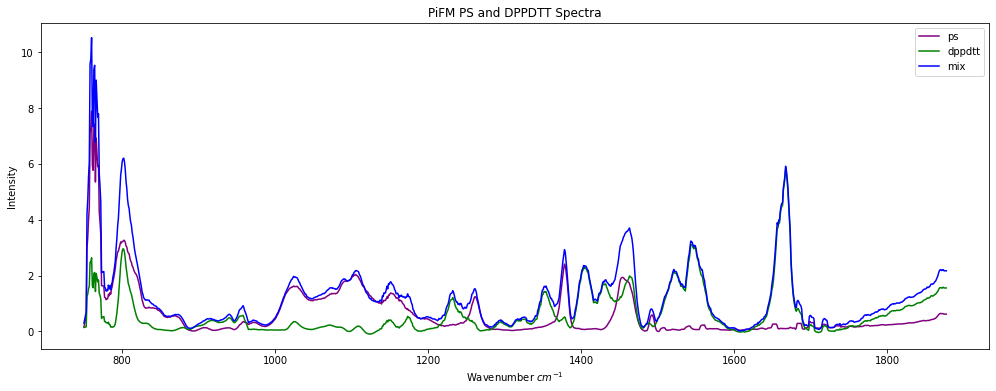

In [11]:
plt.figure(figsize = (17,6))
plt.plot(ps_hyper_wavenumber, ps_sav, label='ps', color='purple')
plt.plot(dppdtt_hyper_wavenumber, dppdtt_sav, label='dppdtt', color='green')
plt.plot(dppdtt_hyper_wavenumber, dppdtt_sav + ps_sav, label = 'mix', color = 'blue')
plt.legend()
plt.xlabel('Wavenumber $cm^{-1}$')
plt.ylabel('Intensity')
plt.title('PiFM PS and DPPDTT Spectra')
plt.show()

In [12]:
dppdtt_hyper_wavenumber.min()

750.0

# Now let's look at an image of a blended PS and DPPDTT

In [0]:
image = np.load('/content/drive/My Drive/UW Chemistry/Courses/CHEM599_Image_processing/Hyperunmixing data/image1.npy')
# I'll hopefully have all our images in this format so it's easy to load into a notebook or code module

In [14]:
image.shape

(256, 256, 1128)

The image size is 256 x 256 and the spectrum depth is 1128 wavenumbers. 

The spectra were collected starting at 750 wavenumbers, so to visualize the spectra at each wavenumber of interest, you have to subtract that 750 starting point.

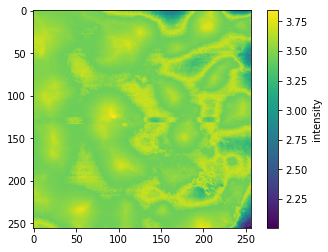

In [15]:
wavenumber_762 = image[:,:,762-750]
plt.imshow(wavenumber_762)
plt.colorbar(label = 'intensity')
plt.show()

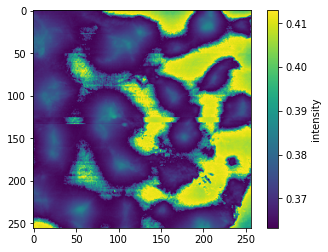

In [16]:
wavenumber_1490 = image[:,:,1490-750]
plt.imshow(wavenumber_1490)
plt.colorbar(label = 'intensity')
plt.show()

### Some ideas for functions for Q2HW3:
- Create 'wavenumber_XXXX' images given a list of wavenumbers of interest
    - Input: list of wavenumbers
    - Output: list of images
- Normalize intensity in images from 0 to 1 (easier to work with?)
    - Input: image
    - Output: normalized image
- Pull average spectra out of entire image (may be sort of brute force but interesting in comparison with pure averaged PS and DPPDTT spectra)
    - Input: image
    - Output: averaged and smoothed spectrum
- Tile images to create larger datasets (possibly we can use 64x64 sized images)
    - Input: 256x256 image
    - Output: X number of 64x64 images

Normalization of images 

In [0]:
new_im=normalization(image)

In [0]:
def normalizaton_1D(func):
    new_func=(func-np.amin(func))/(np.amax(func)-np.amin(func))
    
    return new_func 


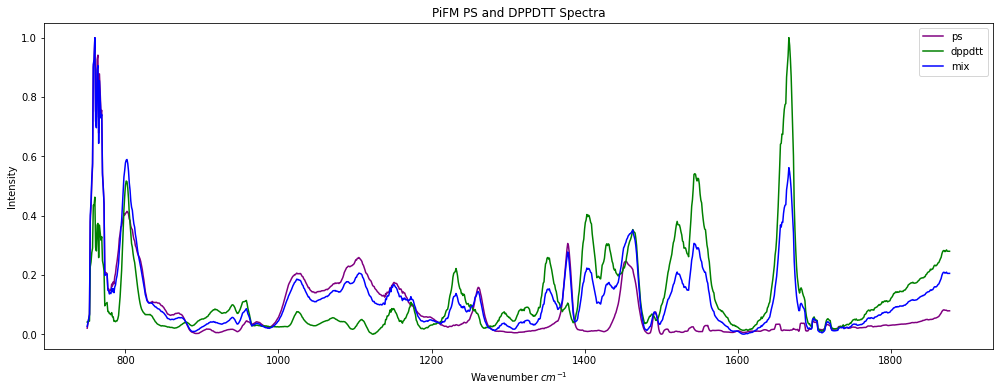

In [52]:
plt.figure(figsize = (17,6))
plt.plot(ps_hyper_wavenumber,normalizaton_1D(ps_sav), label='ps', color='purple')
plt.plot(dppdtt_hyper_wavenumber, normalizaton_1D(dppdtt_sav), label='dppdtt', color='green')
plt.plot(dppdtt_hyper_wavenumber, normalizaton_1D(dppdtt_sav + ps_sav), label = 'mix', color = 'blue')
plt.legend()
plt.xlabel('Wavenumber $cm^{-1}$')
plt.ylabel('Intensity')
plt.title('PiFM PS and DPPDTT Spectra')
plt.show()

In [0]:
sub=new_im[25,25,:]-normalizaton_1D(ps_sav)

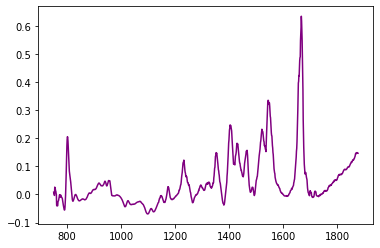

In [54]:
plt.plot(ps_hyper_wavenumber,sub, label='ps', color='purple')